In [150]:
### Install Libraries (run it upon first usage of the script)
# pip install plotnine

In [151]:
### Import Libraries/Functions + Set Country + Initial Word file

# Import libraries
import wbdata as wb                            # World Bank API
import pandas as pd                            # Data analysis
import numpy as np                             # Numerical computing
import datetime as dt                          # Provides classes to manipulate dates & time
import seaborn as sns                          # Data visualization
import docx                                    # Manipulate docx files
import plotnine                                # Replication of ggplot2 R package > Not using it for now, but would be good to try

# Import functions from libraries
from docx.shared import Cm                     # Import 'Cm' function, from 'shared' modules of the 'docx' library
from docx.enum.text import WD_ALIGN_PARAGRAPH  # Import 'WD_ALIGN_PARAGRAPH' function from the 'text' sub-module from 'enum' module of 'docx' library
from matplotlib import pyplot as plt           # Import 'pyplot' function from 'matplotlib' library (but not the overall library)

# Set country of interest
country = 'RUS' # 
# >>> Something else we'll need is to write down 'Russian Federation', instead of 'RUS' in the text and the graphs generated below, whenever country = 'RUS'; and similarly for other countries >>> Could you look for the best way of doing that? We could input the matching from a .csv file that would have a column with the iso 3-digit codes and another column with the country name as per ADB's convention

# Create blank .docx where the output will be exported
doc = docx.Document()

# Add title (heading level 0)
doc.add_heading(f'{country}: Asian Development Outlook', level=0)

In [152]:
### Import & Format GDP data + Components – Expenditure Approach

# Create data dictionary
gdp = {'NY.GDP.MKTP.KD.ZG': 'GDP growth (%)',
       'NE.CON.PRVT.ZS': 'Private consumption (% of GDP)', 
       'NE.CON.GOVT.ZS': 'Government expenditure (% of GDP)',
       'NE.GDI.TOTL.ZS': 'Gross capital formation (% of GDP)', 
       'NE.EXP.GNFS.ZS': 'Exports (% of GDP)',
       'NE.IMP.GNFS.ZS': 'Imports (% of GDP)',
       'NE.CON.PRVT.KD.ZG': 'Private consumption (annual growth, %)', 
       'NE.CON.GOVT.KD.ZG': 'Government expenditure (annual growth, %)',
       'NE.GDI.TOTL.KD.ZG': 'Gross capital formation (annual growth, %)',
       'NE.EXP.GNFS.KD.ZG': 'Exports (annual growth, %)',
       'NE.IMP.GNFS.KD.ZG': 'Imports (annual growth, %)'}

# Set time period (already sorted by 'date', i.e. year)
data_date = dt.datetime(2014, 1, 1), dt.datetime(2019, 1, 1)

# Scrape data from WB API (source=2 = WDI)
df_gdp = wb.get_dataframe(indicators=gdp, country=country, data_date=data_date, source=2)

# Sort data by year
df_gdp = df_gdp.reset_index().sort_values(by='date').reset_index(drop=True)

# Generate share of net exports in GDP
net_exports_share = df_gdp['Exports (% of GDP)'] - df_gdp['Imports (% of GDP)']

# Insert 'net_exports_share' as the 7th column, labeled 'Net exports (% of GDP)'
df_gdp.insert(7, 'Net exports (% of GDP)', net_exports_share)

# Generate contributions to GDP growth 
df_gdp['Private consumption (contribution, pp)'] = df_gdp['Private consumption (% of GDP)'].shift(1) / 100 * df_gdp['Private consumption (annual growth, %)']
df_gdp['Government expenditures (contribution, pp)'] = df_gdp['Government expenditure (% of GDP)'].shift(1) / 100 * df_gdp['Government expenditure (annual growth, %)']
df_gdp['Gross capital formation (contribution, pp)'] = df_gdp['Gross capital formation (% of GDP)'].shift(1) / 100 * df_gdp['Gross capital formation (annual growth, %)']
df_gdp['Exports (contribution, pp)'] = df_gdp['Exports (% of GDP)'].shift(1) / 100 * df_gdp['Exports (annual growth, %)']
df_gdp['Imports (contribution, pp)'] = df_gdp['Imports (% of GDP)'].shift(1) / 100 * df_gdp['Imports (annual growth, %)']

## > Transform the above 5 lines into a loop > Jules' attempt below is not working:
# variables = ["Private consumption", "Government expenditures", "Gross capital formation", "Exports", "Imports"]
# for var_root in variables:
#     df_gdp[var_root, ' (contribution, pp) Test'] = df_gdp[var_root, ' (% of GDP)'].shift(1) / 100 * df_gdp[var_root,' (annual growth, %)']

# Generate net export contribution to GDP growth
df_gdp['Net exports (contribution, pp)'] = df_gdp['Exports (contribution, pp)'] - df_gdp['Imports (contribution, pp)']

# Round to one decimal
df_gdp = df_gdp.round(1)

# Create dataframe for top three sources of growth
top_share = pd.DataFrame(df_gdp.iloc[-1, [2, 3, 4, 7]].sort_values(ascending=False))    # -1 = last element > In this case = last row
top_share.columns = ['share']                                                           # Change col. name: '5' > 'share'
new_index = [i[:-11] for i in top_share.index]                                          # Remove last 11 elements of the col. title string > foreach 'i' row in 'top_share'
top_share.index = new_index


In [153]:
### GDP Growth Section
  
# Set year placeholders (re-used by several data frames below)
latest_year = df_gdp['date'].iloc[-1]
penultimate_year = df_gdp['date'].iloc[-2]               # Note to delete once read: penultimate = n-2, antepenultimate = n-3

# Set variable placeholders (> here, for GDP growth, but can pbbly be looped acroos the several variables for which the operation is repeated)
latest_gdp_growth = df_gdp.iat[-1, 1]                    # 'iat' selects cell / 'iloc' selects range
penultimate_gdp_growth = df_gdp.iat[-2, 1]
increased = latest_gdp_growth > penultimate_gdp_growth
f_string = 'increased' if increased else 'decreased'

# Add heading + paragraph – GDP growth last 2 years
doc.add_heading(f'GDP growth in {latest_year}', level=1) # {} incorporates object/variable inside a string
p = doc.add_paragraph(f'Overall GDP growth: GDP growth {f_string} from {penultimate_gdp_growth}% in {penultimate_year} \
to {latest_gdp_growth}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set GDP component contributions shares (expenditure approach) placeholders 
top_one_share = top_share.iat[0, 0]
top_one_var = top_share.index[0]
top_two_share = top_share.iat[1, 0]
top_two_var = top_share.index[1]
top_three_share = top_share.iat[2, 0]
top_three_var = top_share.index[2]
least_share = top_share.iat[3, 0]
least_share_var = top_share.index[3]
positive, negative = least_share > 0, least_share < 0
f_string = 'positive' if positive else 'negative'
    
# Add paragraph – Top 3 contributions to GDP change
p = doc.add_paragraph(f'Top 3 contributions with {top_one_var} contributing the most ({top_one_share}%), \
followed by {top_two_var} ({top_two_share}%) and {top_three_var} ({top_three_share}%).', 
                   style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add paragraph – Negative contribution to GDP change
p = doc.add_paragraph(f'Contributions in the opposite direction of overall growth: On the other hand, \
{least_share_var} had a {f_string} contribution at {least_share}% of GDP.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY


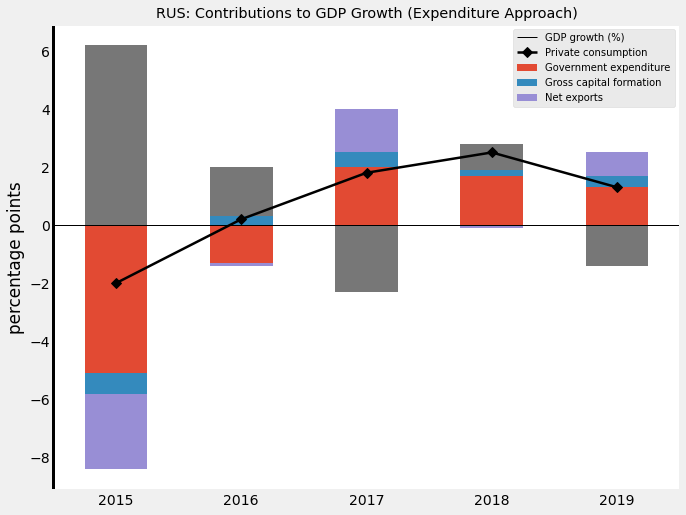

In [154]:
### GDP Growth Contributions Plot – Expenditure Approach

# Create dataframe to plot
df_graph = df_gdp.iloc[:, [0, 1, 13, 14, 15, 18]].dropna()    # dropna > Drop missing values

# Create blank canvas + axis >>> Also change font used in the graph to the same as in the paragraphs (i.e. Cambria)
fig, ax = plt.subplots(figsize=(10, 8))                       # 'fig' creates the figure / 'ax' creates axis
plt.style.use('ggplot')                                       # Select scheme > ggplot to make it look like R plot
ax.set_facecolor('xkcd:white')                                # Set inner background to white
                                                              # >>> Set outer background to white as well
ax.spines['left'].set_color('black')                          # Set y-axis color to black 
                                                              # >>> Also make the linewidth thinner
plt.axhline(y=0, xmin=0, xmax=1, lw=1, color='black')         # Add horizontal line
ax.tick_params(colors='black')                                # Set axis labels to black
ax.yaxis.label.set_color('black')                             # Set axis title to black

# Create stacked bar chart of the components
df_graph.set_index('date').iloc[:, 1:].plot(kind='bar', stacked=True, ax=ax) #Select all rows–All columns from the 1st one (i.e. excluding the 0 column, which is date)

# Create line plot of the GDP growth series
ax.plot(df_graph['date'], df_graph.iloc[:, 1], lw=2.5, marker='D', markersize=7, color='black')

# Set legend
ax.legend(['GDP growth (%)', 'Private consumption', 'Government expenditure', 
           'Gross capital formation', 'Net exports'])         # Manually set legend keys

# Set graph formatting + Save to local folder
ax.set_title(f'{country}: Contributions to GDP Growth (Expenditure Approach)')
ax.set_ylabel('percentage points')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.grid(False)
plt.savefig(f'{country}_GDP_components.png')

# Add plot to .docx
graph = doc.add_picture(f'{country}_GDP_components.png', width=Cm(10), height=Cm(7))
last_paragraph = doc.paragraphs[-1]                           # Define last paragraph (i.e. the plot), because the 'alignment' function only applies to paragraphs (not directly graphs)
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [155]:
### GDP Expenditure Approach Section

# Set placeholders
private_consumption_growth_latest = df_gdp.iat[-1, 8]
private_consumption_growth_penultimate = df_gdp.iat[-2, 8]
private_consumption_contribution = df_gdp.iat[-1, 13]
accelerated = private_consumption_growth_latest > private_consumption_growth_penultimate
f_string = 'accelerated' if accelerated else 'contracted'

# Add heading + paragraph (private consumption growth)
doc.add_heading(f'Expenditure approach', level=1)
p = doc.add_paragraph(f'Private consumption: Private consumption growth {f_string} to \
{private_consumption_growth_latest}% ({private_consumption_growth_penultimate}% in {penultimate_year}), \
contributing {private_consumption_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
govt_expenditure_growth_latest = df_gdp.iat[-1, 9]
govt_expenditure_growth_penultimate = df_gdp.iat[-2, 9]
govt_expenditure_contribution = df_gdp.iat[-1, 14]
accelerated = govt_expenditure_growth_latest > govt_expenditure_growth_penultimate
f_string = 'accelerated' if accelerated else 'contracted'

# Add paragraph – Government expenditure growth
p = doc.add_paragraph(f'Government expenditures: Government expenditures growth {f_string} to \
{govt_expenditure_growth_latest}% ({govt_expenditure_growth_penultimate}% in {penultimate_year}), \
contributing {govt_expenditure_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders
gross_cap_formation_growth_latest = df_gdp.iat[-1, 10]
gross_cap_formation_growth_penultimate = df_gdp.iat[-2, 10]
gross_cap_formation_contribution = df_gdp.iat[-1, 15]
accelerated = gross_cap_formation_growth_latest > gross_cap_formation_growth_penultimate
f_string = 'increased' if accelerated else 'contracted'

# Add paragraph – Gross capital formation growth
p = doc.add_paragraph(f'Gross capital formation: Growth in gross capital formation {f_string} to \
{gross_cap_formation_growth_latest}% ({gross_cap_formation_growth_penultimate}% in {penultimate_year}), \
contributing {gross_cap_formation_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Set placeholders >>> Loop structure as this is common to several variables
exports_growth_latest = df_gdp.iat[-1, 11]
exports_growth_penultimate = df_gdp.iat[-2, 11]
exports_contribution = df_gdp.iat[-1, 16]
accelerated = exports_growth_latest > exports_growth_penultimate
f_string = 'increased' if accelerated else 'decreased'

# Add paragraph – Export growth >>> This should be net exports, not just exports
p = doc.add_paragraph(f'Exports: Growth in Exports {f_string} to \
{exports_growth_latest}% ({exports_growth_penultimate}% in {penultimate_year}), \
contributing {exports_contribution} percentage points to overall growth.', \
                  style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [156]:
### Industrial Production (output approach) >>> This should be looped across the variables for which subsequent code follows a similar structure (e.g. next box)

# Create data dictionnary
industrial_production = {'NV.IND.TOTL.KD.ZG': 'Industry (including construction), value added (annual growth, %)'}

# Scrape data from WB API >> Could this be scrapped all at once, i.e. together w/ other variables scraped from WB API?
df_industry = wb.get_dataframe(indicators=industrial_production, 
                               country=country, data_date=data_date, source=2)

# Sort data by year
df_industry = df_industry.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_industry = df_industry.round(1)

# Set placeholders
industrial_production_growth_latest = df_industry.iat[-1, 1]
industrial_production_growth_penultimate = df_industry.iat[-2, 1]
expanded = industrial_production_growth_latest > 0
up = industrial_production_growth_latest > industrial_production_growth_penultimate
f_string_1 = 'expanded' if expanded else 'shrank'      # No need to define 'shrank' object above as 'else' here?
f_string_2 = 'up' if up else 'down'

# Add heading + paragraph
doc.add_heading(f'Industrial approach', level=1)
p = doc.add_paragraph(f'Industrial production: Industrial production {f_string_1} by \
{industrial_production_growth_latest}%, {f_string_2} from {industrial_production_growth_penultimate}% growth \
in {penultimate_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [157]:
### Unemployment

# Create data dictionnary
unemployment_rate = {'SL.UEM.TOTL.NE.ZS': 'Unemployment rate (%)'}

# Set time period
data_date = dt.datetime(2014, 1, 1), dt.datetime(2019, 1, 1)

# Scrape data from WB API
df_unemployment = wb.get_dataframe(indicators=unemployment_rate,
                                   country=country, data_date=data_date, source=2)

# Sort data by year
df_unemployment = df_unemployment.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_unemployment = df_unemployment.round(1)

# Set placeholders
unemployment_rate_latest = df_unemployment.iat[-1, 1]
unemployment_rate_penultimate = df_unemployment.iat[-2, 1]
improved = unemployment_rate_latest < unemployment_rate_penultimate
f_string = 'improved' if improved else 'worsened'

# Add heading + paragraph
doc.add_heading(f'Income approach', level=1)
p = doc.add_paragraph(f'Employment: Unemployment {f_string} from {unemployment_rate_penultimate}% in \
of total labor force in {penultimate_year} to {unemployment_rate_latest}% in {latest_year}.', 
                      style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

In [158]:
### Inflation

# Create data dictionnary
inflation = {'FP.CPI.TOTL.ZG': 'Inflation rate (%)'}

# Set time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape data from WB API
df_inflation = wb.get_dataframe(indicators=inflation, country=country, data_date=data_date, source=2)

# Sort data by year
df_inflation = df_inflation.reset_index().sort_values(by='date').reset_index(drop=True)

# Round to one decimal
df_inflation = df_inflation.round(1)

# Set placeholders
inflation_latest = df_inflation.iat[-1, 1]
inflation_penultimate = df_inflation.iat[-2, 1]
slowed, remained = inflation_latest < inflation_penultimate, inflation_latest == inflation_penultimate
f_string = ''
if slowed:
    f_string = 'slowed down'
elif remained:
    f_string = 'remained stable'
else:
    f_string = 'picked up'

# Add heading + paragraph
doc.add_heading(f'Inflation', level=1)
p = doc.add_paragraph(f'Inflation & monetary policy: Inflation {f_string} from \
{inflation_penultimate}% in {penultimate_year} to {inflation_latest}% in {latest_year}.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

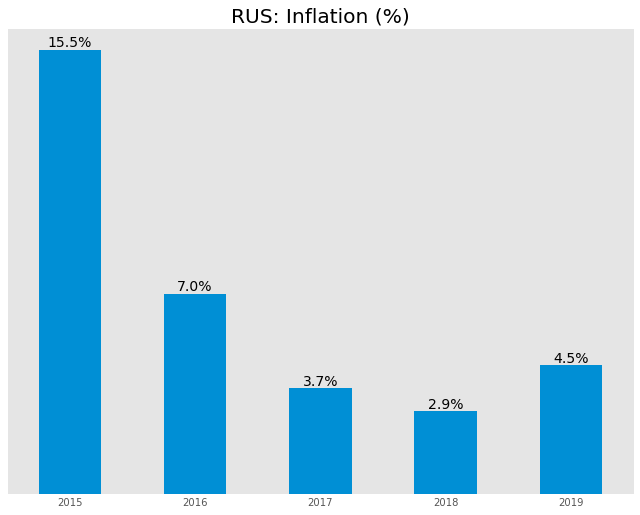

In [159]:
### Inflation plot

# Create blank canvas
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')

# Create dataframe of the inflation chart
df_graph = df_inflation.drop(index=0).reset_index(drop=True).set_index('date')

# Create bar chart of inflation
df_graph.plot(kind='bar', ax=ax)

# Set legend off
ax.get_legend().remove()

# Set graph formatting
ax.set_title(f'{country}: Inflation (%)')
ax.grid(False)
ax.set_xlabel('')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0)

# Set data labels
labels = df_graph['Inflation rate (%)']

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(label) + '%',
            ha='center', va='bottom')

# Save to local folder
plt.savefig(f'{country}_inflation.png')

# Add picture to the document
graph = doc.add_picture(f'{country}_inflation.png', width=Cm(10), height=Cm(7))
last_paragraph = doc.paragraphs[-1]
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

In [160]:
### FX Reserves

# Create data dictionnary
reserves = {'FI.RES.TOTL.CD': 'Total reserves (includes gold, current USD)',
            'FI.RES.TOTL.MO': 'Total reserves in months of imports'}

# Set time period
data_date = dt.datetime(2019, 1, 1), dt.datetime(2014, 1, 1)

# Scrape data from WB API
df_reserves = wb.get_dataframe(indicators=reserves, country=country, data_date=data_date, source=2)

# Sort data by year
df_reserves = df_reserves.reset_index().sort_values(by='date').reset_index(drop=True)

# Convers to $ billion
df_reserves.iloc[:, 1] = df_reserves.iloc[:, 1] / 1e9

# Round to one decimal
df_reserves = df_reserves.round(1)

# Set placeholders
reserves_latest = df_reserves.iat[-1, 1]
reserves_imports_latest = df_reserves.iat[-1, 2]
strong, weak = reserves_imports_latest >= 12, reserves_imports_latest < 12
f_string = 'strong' if strong else 'weak'

In [161]:
df_reserves

,date,"Total reserves (includes gold, current USD)",Total reserves in months of imports
0,2014,386.2,8.5
1,2015,368.0,12.4
2,2016,377.1,13.2
3,2017,432.7,12.5
4,2018,468.6,12.9
5,2019,555.2,14.5


In [162]:
### Outlook section

# Add heading
doc.add_heading('Outlook', level=1)

# Add paragraph on Confidence index
p = doc.add_paragraph('Confidence index', style='List Number')

# Add paragraph on Monetary policy, FX, Inflation
p = doc.add_paragraph(f'FX reserves: Foreign exchange reserves by the central bank  amounted to \
${reserves_latest} in {latest_year}, putting the government in a {f_string} position to defend the \
currency against devaluation pressures.', style='List Number')
p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# Add paragraph on Fiscal policy
p = doc.add_paragraph('Fiscal policy', style='List Number')

# Add paragraph on Current events
p = doc.add_paragraph('Comments on current events', style='List Number')

# Add paragraph on leading indicators
p = doc.add_paragraph('Leading indicators', style='List Number')

# Add paragraph on Consensus Forecasts
p = doc.add_paragraph('Consensus Forecasts', style='List Number')

# Add paragraph on Risks
p = doc.add_paragraph('Risks', style='List Number')

In [163]:
doc.save(f'{country} ADO Quick Report.docx')